# Deep Convolution Generative Advarsarial Network 

Here is presented the implementation of the following parper https://arxiv.org/abs/1511.06434

Implementation is done in tensorflow using KERAS API

Created by: Tiago Almeida 17/08/2018

In [9]:
##Reproduceble work
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)


##imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization
import tensorflow.keras.backend as K
#tensorflow version when notebook was created - 1.9.0
tf.__version__


'1.9.0'

### Data MNIST

In [ ]:
mnist_flat_size = 784

#mnist data

(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()


x_train = x_train.astype('float32')
x_test = x_test.reshape([-1,mnist_flat_size]).astype('float32')

#rescale the image to [-1,1] range
x_train = x_train/ 127.5 - 1
x_test = x_test/ 127.5 - 1

#rescale the image to [0,1] range
#x_train = x_train/ 255
#x_test = x_test/ 255

print("Shape of the training images",x_train.shape)

ut.plot_mnist_2dimages(x_train[0:9])

#reset graph using during notebook development
K.clear_session()



### Generator network 
In this implementation i use Functional Keras API for creating the network

* 2 Deconvolution layers
* No pooling layers
* Batch normalization after convolution and before activation
* Relu and tanh for output 

Kernel and stride size are the same as the generator

Note: I want that my final image have dimention $28 = 7\times2\times2$, so i can start with 7x7 image and upscale it by deconvolutions operations (with stride 2x2 and padding the image with zeros) the result would be a image with 14x14 and doing the same upscaling i get the final image with the size 28x28 (same as mnist :D)

TODO: analyse some problems like "mode colapse"

In [ ]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2DTranspose, Reshape, Activation, LeakyReLU

from tensorflow.keras.optimizers import Adam

#Dimention of random vector using for sampling
z = 100

g_input = Input(shape=[z], name="g_input")
H = Dense(7*7*64)(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape((7,7,64))(H)
H = Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2, 2), padding='same')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2DTranspose(filters=1, kernel_size=(5,5), strides=(2, 2), padding='same')(H)
#g_output = Activation('sigmoid')(H)
H = Activation('tanh', name="g_tanh")(H)
g_output = Reshape((28,28))(H)


generator = Model(g_input,g_output, name="generator")
#No need to compile because he will use train with adversarial method
generator.summary()


### Discriminator network 

* 2 Convolution layers
* No pooling layers
* Batch normalization after convolution and before activation
* Leaky relu (alpha 0.2 tensorflow default)

Kernel and stride size are the same as the generator

In [4]:
from tensorflow.keras.layers import Conv2D, Flatten, Dropout


d_optimizer = Adam(lr=1e-4,beta_1=0.1)
drop_rate = 0.5

d_input = Input(shape=[28,28],  name="d_input")
H = Reshape((28,28,1))(d_input)
H = Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), padding='same')(H)
H = BatchNormalization()(H)
H = LeakyReLU(alpha=0.2)(H)
H = Conv2D(filters=32, kernel_size=(5,5), strides=(2, 2), padding='same')(H)
H = BatchNormalization()(H)
H = LeakyReLU(alpha=0.2)(H)
H = Flatten()(H)
H = Dense(7*7*32)(H)
H = LeakyReLU(alpha=0.2)(H)
#H = Dropout(drop_rate)(H)
H = Dense(256)(H)
H = LeakyReLU(alpha=0.2)(H)
#H = Dropout(drop_rate)(H)
H = Dense(1)(H)
d_output = Activation('sigmoid')(H)

"""
d_input = Input(shape=[mnist_flat_size],  name="d_input")
H = Dense(512)(d_input)
H = LeakyReLU(alpha=0.2)(H)
H = Dense(128)(H)
H = LeakyReLU(alpha=0.2)(H)
H = Dense(1)(H)
d_output = Activation('sigmoid')(H)
"""
discriminator = Model(d_input,d_output, name="discriminator")
discriminator.compile(loss='binary_crossentropy', optimizer=d_optimizer)
discriminator.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_input (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          51232     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 32)          128       
__________

### Adversarial Model

Used to train the generator

In [7]:

def make_trainable(net, val=True):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

def print_net_trainable(net):
    print(net.name,net.trainable)
    for l in net.layers:
        print(l.name,l.trainable)
        
# Freeze weights in the discriminator for adversarial training
#make_trainable(discriminator, False)
discriminator.trainable = False
gan_optimizer = Adam(lr=2e-4,beta_1=0.3)

# Build stacked GAN model to train the generator
gan_input = Input(shape=[z], name="gan_z_input")
gan_fake_samples = generator(gan_input)
gan_output = discriminator(gan_fake_samples)

gan = Model(gan_input, gan_output, name="generator_adversarial")
gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gan_z_input (InputLayer)     (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28)            433601    
_________________________________________________________________
discriminator (Model)        (None, 1)                 2915393   
Total params: 3,348,994
Trainable params: 427,201
Non-trainable params: 2,921,793
_________________________________________________________________


### Training Algorithm


discriminator False
d_input False
reshape_2 False
conv2d False
batch_normalization_2 False
leaky_re_lu False
conv2d_1 False
batch_normalization_3 False
leaky_re_lu_1 False
flatten False
dense_1 False
leaky_re_lu_2 False
dense_2 False
leaky_re_lu_3 False
dense_3 False
activation_2 False
generator_adversarial True
gan_z_input True
generator True
discriminator False
Discriminator loss:  0.024786443
Generator loss: 0.22485897


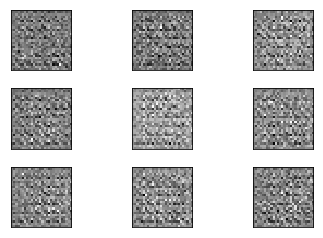

discriminator False
d_input False
reshape_2 False
conv2d False
batch_normalization_2 False
leaky_re_lu False
conv2d_1 False
batch_normalization_3 False
leaky_re_lu_1 False
flatten False
dense_1 False
leaky_re_lu_2 False
dense_2 False
leaky_re_lu_3 False
dense_3 False
activation_2 False
generator_adversarial True
gan_z_input True
generator True
discriminator False
discriminator False
d_input False
reshape_2 False
conv2d False
batch_normalization_2 False
leaky_re_lu False
conv2d_1 False
batch_normalization_3 False
leaky_re_lu_1 False
flatten False
dense_1 False
leaky_re_lu_2 False
dense_2 False
leaky_re_lu_3 False
dense_3 False
activation_2 False
generator_adversarial True
gan_z_input True
generator True
discriminator False


KeyboardInterrupt: 

In [8]:
#try shuffle the data
from sklearn.utils import shuffle


def random_Z(m, n=z):
    '''
    Random values for Z between -1 and 1
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return np.random.uniform(-1., 1., size=[m, n])

## Start graph computations and algorithm


batch_size = 256 #must be multiple of 2
epoach = 75000

##check summary again
#make_trainable(discriminator,True)
#discriminator.summary()
#make_trainable(discriminator,False)
#gan.summary()

#save losses 
losses = {}
losses["gan_loss"] = []
losses["d_loss"] = []

visualize_samples = random_Z(9)


#make_trainable(generator,True)


for i in range(epoach):
    
    #generate images
    synthetic_images = generator.predict_on_batch(random_Z(batch_size//2))
    #select from tranning set
    real_images = x_train[np.random.randint(0,x_train.shape[0],size=batch_size//2),:,:]
    
    d_x = np.concatenate((synthetic_images, real_images))
    d_y = np.zeros([batch_size,1])
    
    d_y[batch_size//2:] = 1 #second half of the batch are true images so have label 1 and fake (first half) have label 0
        
    #print("d_x shape",d_x.shape)
    #print("d_y shape",d_y.shape)    
 
    

    #first discriminator
    #make_trainable(discriminator,True)
    d_loss = discriminator.train_on_batch(d_x,d_y)
    
    #second generator in adversarail faction
    gan_x = random_Z(batch_size)
    gan_y = np.ones([batch_size,1])
    #print("gan_x shape",gan_x.shape) 
    #print("gan_y shape",gan_y.shape)
    #print(gan_y)
    #make_trainable(discriminator,False)
    gan_loss = gan.train_on_batch(gan_x,gan_y)
    
    print_net_trainable(discriminator)
    print_net_trainable(gan)
    
    losses["gan_loss"] += [gan_loss]
    losses["d_loss"] += [d_loss]
    
    print("Epoach",i,end='\r')
    
    if i%250 == 0:
       
        print("Discriminator loss: ",d_loss)
        print("Generator loss:",gan_loss)

  
        #sample 9 images from generator
        generated_images = generator.predict_on_batch(visualize_samples)
        ut.plot_mnist_2dimages(generated_images)
    
print("Discriminator loss: ",d_loss)
print("Generator loss:",gan_loss)


#sample 9 images from generator
generated_images = generator.predict_on_batch(random_Z(9))
ut.plot_mnist_2dimages(generated_images)

print("\n Plot learning curves \n")

plt.plot(losses["gan_loss"], label='generative loss')
plt.plot(losses["d_loss"], label='discriminitive loss')
plt.legend()
plt.show()


In [ ]:
generated_images = generator.predict_on_batch(random_Z(9))


print(discriminator.predict_on_batch(generated_images))

### Analysing noise Z

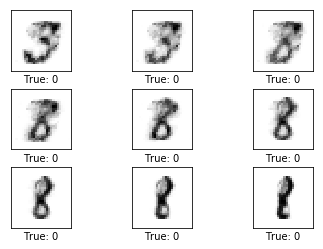